# Lab session of 17/05/2023

## Problem 1: Capacitated Vehicle Routing Problem

The Capacitated Vehicle Routing Problem (CVRP) is a generalization of the Traveling Salesman Problem (TSP) where a fleet of vehicles $K$ is available to serve a set of customers. Each vehicle has a limited capacity and the goal is to find a set of routes that minimizes the total travel cost while serving all customers and respecting the capacity constraint of each vehicle.

In particulat, let $G = (V, A)$ be a complete graph, where $V = \{0,...,n\}$ is the vertex set and $A$ is the arc set. Vertices $i = 1,...,n$ correspond to the customers, whereas vertex $0$ corresponds to the depot. A nonnegative cost, $c_{ij}$, is associated with each arc $(i,j) \in A$ and represents the travel cost spent to go from vertex $i$ to vertex $j$. We suppose that $c_{ii} = \infty$ for all $i \in V$.

Each customer $i \in V$ is associated with a known nonnegative demand to be delivered, $d_i$, and the depot has a fictitious demand $d_0 = 0$. 

A set $K$ of identical vehicles, each with capacity $C$, is available at the depot. To ensure feasibility we assume that $d_i \le C$ for each $i \in V$ and that we have a sufficient amount of vehicles to serve all customers.

Given a vertex set $S \subseteq V \setminus \{0\}$, let $d(S) = \sum_{i \in S}{d_i}$ denote the total demand of the set. We denote with $r(S)$ the minimum number of vehicles needed to serve the total demand of $S$, i.e., $r(S) = \lceil d(S)/C \rceil$.

The CVRP consists of finding a collection of vehicle routes with minimum cost, defined as the sum of the costs of the arcs belonging to each route, and such that:
* each route starts and finishes at the depot vertex;
* each customer vertex is visited by exactly one route; 
* the sum of the demands of the vertices visited by a route does not exceed the vehicle's capacity $C$.

## Two-index vehicle flow formulation 

Let $x_{ij} \forall (i,j) \in A$ be a binary variable whose value is 1 if a vehicle travels along arc $(i,j)$ and 0 otherwise. The two-index vehicle flow formulation of the CVRP is the following:

$$
\begin{array}{lll}
   \min & \sum_{(i,j) \in A} c_{ij} x_{ij}\\
   \textrm{s.t.} & \sum_{i \in V} x_{ij} = 1 & \forall j \in V \setminus \{0\} \\
                 & \sum_{i \in V} x_{ji} = 1 & \forall j \in V \setminus \{0\} \\
                 & \sum_{i \in V} x_{i0} = K & \\
                 & \sum_{i \in V} x_{0i} = K & \\
                 & \sum_{i \in S}{\sum_{j \in S}{x_{ij}}} \le |S| - r(S) & \forall S \subseteq V \setminus \{0\}: S \neq \varnothing \\
                 & x_{ij} \in \{0,1\} & \forall (i,j) \in A
\end{array}
$$

## Exercise

1. Generate $k$ random customers by creating random $x,y$ coordinates for each; the coordinates should be in the interval $[0,100]$. Generate also a random demand for each customer, with values in the interval $[1,10]$;
2. Assume the graph $G = (V,A)$ on which to solve the CVRP is _complete_, i.e. any two pairs are connected by an edge;
3. Create the optimization model for the CVRP without adding any subtour elimination constraints;
4. Iteratively solve the optimization model and then add subtour elimination constraints until the solution is a single (optimal) tour.

## Solution

In [1]:
# When using Colab, make sure you run this instruction beforehand
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 49.3 MB/s eta 0:00:00


In [1]:
import numpy as np
import math

n = 8       # number of nodes
max_d = 10  # max demand per node
C = 30      # capacity of each vehicle

grid_size = 100 # size of the grid of points

np.random.seed(1337)

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.
point = grid_size * np.random.random((n,2))

d = np.random.choice(np.arange(1, max_d), size=n)
d[0] = 0

k = int(np.ceil(np.sum(d) / C))

K = [i for i in range(k)]

# Define the set of vertices of the graph as the list of numbers from 0 to k-1
V = [i for i in range(n)]

# Determine the distance between each point
c = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

# Set C[i,i] to an arbitrarily large value to forbid usage of x[i,i]
for i in V:
  c[i,i] = 10000000

[0 4 4 5 9 9 8 5]


Let's plot these points on the grid. We use `matplotlib` and specifically the function `matplotlib.pyplot`. We then create a complete graph and draw it on the grid.

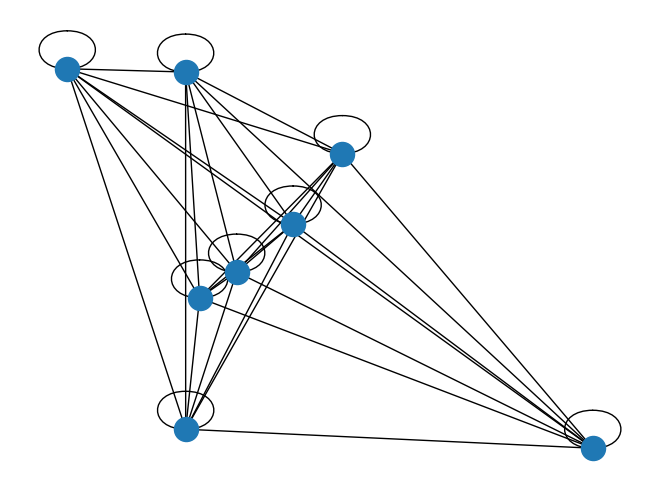

In [2]:
import networkx as nx

# Set of arcs
A = [(i,j) for i in V for j in V ]

# Define a dictionary whose keys are the nodes, and the values are tuples
# containing the (x,y) coordinates of each point
coord = {i: (point[i,0], point[i,1]) for i in V}

g = nx.Graph()

g.add_nodes_from(V)
g.add_edges_from(A)

nx.draw(g, pos=coord)

In [3]:
# Create model, add variables
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY, name="x{}{}".format(str(i), str(j))) for i in V for j in V}

# Add conservation constraints
for j in V:
    num_outgoing_arcs = num_ingoing_arcs = 1
    if j == 0:
      num_outgoing_arcs = num_ingoing_arcs = k
      
    m += mip.xsum(x[i,j] for i in V) == num_ingoing_arcs
    m += mip.xsum(x[j,i] for i in V) == num_outgoing_arcs

m.objective = mip.minimize(mip.xsum(x[i,j] * c[i,j] for (i,j) in A))
status = m.optimize()

print(m.objective_value)
print(status)

229.99788176429928
OptimizationStatus.OPTIMAL


We can rewrite the function for drawing the MIP solution, which might contain subtours.

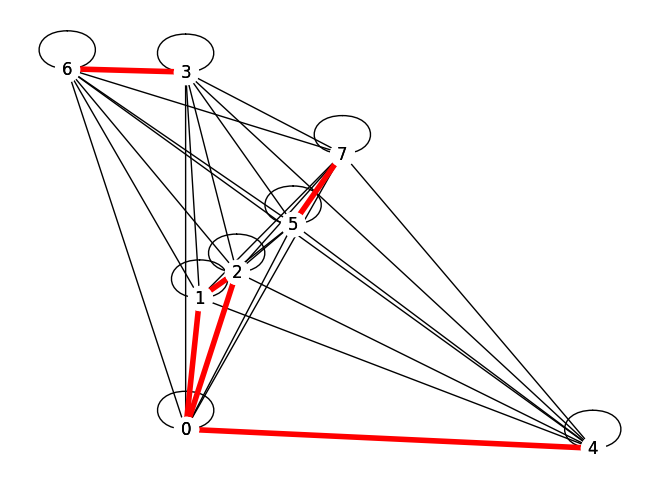

In [4]:
def draw_solution(V, A, x):
    g = nx.Graph()

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=coord, with_labels=True, node_color="white")

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable x[i,j] is nonzero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if x[i,j].x > 0.5])
    nx.draw(g, pos=coord, width=4, edge_color='red', with_labels=True, node_color='white')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: coord[0]}, node_color='white', with_labels=True)

    
# after defining the function, call it with the current data
draw_solution (V, A, x)

Did we get subtours? If so, we must separate (generate) subtour elimination constraints. We do it by hand for the first iteration.

Let's start by defining a function to compute $r(S) = ⌈(\sum_{i \in S}d_i) / C⌉$

In [5]:
def r(S):
  sum_d = sum([d[i] for i in S])
  return int(np.ceil(sum_d/C))

OptimizationStatus.OPTIMAL


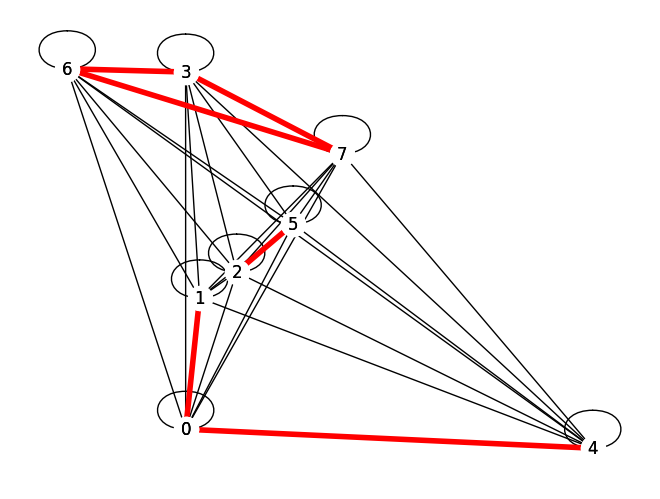

In [6]:
# Add single subtour elimination constraint and reoptimize
m += x[3,6] + x[6,3] <= 2 - r([3,6])
status = m.optimize()
print(status)
draw_solution (V, A, x)

## How do we make this automatic? 

How do we repeat this step by adding the appropriate subtour-elimination constraint until we find valid routes?



In [7]:
# returns a list of cycles (list of vertices) in the solution
def get_cycles(V, A, x):
  graph = [[] for i in V]

  for (i,j) in A:
    if x[i,j].x > 0.5:
      graph[i].append(j)

  cycles = []
  color = [0 for i in V]
  par = [-1 for i in V]

  for i in V:
    if par[i] == -1:
      dfs_cycle(graph, cycles, i, -1, color, par)

  # special handling of cycles with 2 nodes which are not detected by DFS on directed graphs
  for u in V:
    adj = [v for v in graph[u] if v > u]
    for v in adj:
      if u in graph[v]:
        cycles.append([u,v])

  return [c for c in cycles if len(c) < len(V) and len(c) > 0 and not 0 in c]

# depth first search algorithm
def dfs_cycle(graph, cycles, u, p, color, par):

    # skip completely visited vertex.
    if color[u] == 2:
        return

    # If vertex has been seen but not completely visited -> cycle detected.
    # Backtrack based on parents to find the complete cycle.
    if color[u] == 1:
        v = []
        cur = p
        v.append(cur)
 
        # backtrack the vertex which are
        # in the current cycle thats found
        while cur != u:
            cur = par[cur]
            v.append(cur)

        cycles.append(v)
        return
 
    par[u] = p
 
    # partially visited.
    color[u] = 1
 
    # simple dfs on graph
    for v in graph[u]:
        # if it has not been visited previously
        if v == par[u]:
            continue
        dfs_cycle(graph, cycles, v, u, color, par)
 
    # completely visited.
    color[u] = 2

Added constraint cycke= [3, 6] r= 1
Added constraint cycke= [5, 7] r= 1
Added constraint cycke= [6, 7, 3] r= 1
Added constraint cycke= [2, 5] r= 1
Added constraint cycke= [6, 5, 7, 3] r= 1
Added constraint cycke= [6, 3, 7, 5, 2] r= 2
Added constraint cycke= [1, 2] r= 1
Checking route [0, 2, 1, 6, 3, 7, 5, 0]
Infeasible with total demand [0, 2, 1, 6, 3, 7, 5, 0] > 35
Checking route [0, 4, 0]
Added constraint cycke= [2, 1, 6, 3, 7, 5] r= 2
Checking route [0, 1, 2, 0]
Checking route [0, 6, 3, 7, 5, 4, 0]
Infeasible with total demand [0, 6, 3, 7, 5, 4, 0] > 36
Added constraint cycke= [6, 3, 7, 5, 4] r= 2
Checking route [0, 1, 2, 4, 0]
Checking route [0, 6, 3, 7, 5, 0]
331.3274759483226


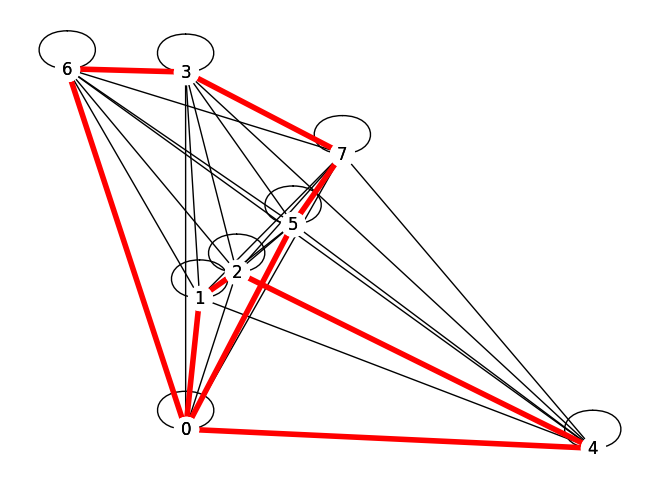

In [8]:
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY, name="x{}{}".format(str(i), str(j))) for i in V for j in V}

# Add conservation constraints
for j in V:
    num_outgoing_arcs = num_ingoing_arcs = 1
    if j == 0:
      num_outgoing_arcs = num_ingoing_arcs = k
      
    m += mip.xsum(x[i,j] for i in V) == num_ingoing_arcs
    m += mip.xsum(x[j,i] for i in V) == num_outgoing_arcs

m.objective = mip.minimize(mip.xsum(x[i,j] * c[i,j] for (i,j) in A))
m.optimize()


cycles = get_cycles(V, A, x)
while len(cycles) > 0:
  for cycle in cycles:
    cycle_edges = [x[i,j] for (i,j) in A if i in cycle and j in cycle]
    m += mip.xsum(cycle_edges) <= len(cycle) - r(cycle)
    print("Added constraint cycke=", cycle, "r=", r(cycle))

  m.optimize()
  cycles = get_cycles(V, A, x)

  if len(cycles) == 0:
    # check if routes that do not have subtours respect capacity constraints.
    # In case they violate it, add them as a cycle (excluding the depot)

    # loop through every edge [0,j]. if x[0,j] == 1 then there's a route 
    # starting from the depot and with j as first node.
    for j in V:
      if j == 0:
        continue
      
      if x[0,j].x > 0.1:
        route = [0,j]
        prev = route[-1]
        while prev != 0:
          succ = -1
          for k in V:
            if k == prev:
              continue
            if x[prev,k].x > 0.1:
              succ = k
              break
          route.append(succ)
          if succ == -1:
            raise ValueError("Something went wrong with route={}".format(route))
          prev = route[-1]

        print("Checking route {}".format(route))
        sum_d = sum([d[v] for v in route])
        if sum_d > C:
          print("Infeasible with total demand {} > {}".format(route, sum_d, C))
          cycles.append(route[1:-1])
      
        

print(m.objective_value)
draw_solution (V, A, x)

## How this performs w.r.t. a model with all subtour-elimination constraints?



In [ ]:
def solve_with_cut_generation(V, E, distance):
  m = mip.Model()

  x = {(i,j): m.add_var(var_type=mip.BINARY, name="x{}{}".format(str(i), str(j))) for (i,j) in E}

  for i in V:
      m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                  mip.xsum(x[i,j] for j in V if j > i) == 2)

  m.objective = mip.minimize(mip.xsum(distance[i,j] * x[i,j] for (i,j) in E))
  m.optimize()

  cycles = get_cycles(V, E, x)
  iters = 0
  while len(cycles) > 0:
    for cycle in cycles:
      cycle_edges = [x[i,j] for (i,j) in E if i in cycle and j in cycle and i < j]
      c = m.add_constr(mip.xsum(cycle_edges) <= len(cycle_edges) - 1)
      print("Added:", c)

    m.optimize()
    cycles = get_cycles(V, E, x)
    iters += 1
    if iters > 10:
      break

  return m.objective_value


def solve_with_complete_model(V, E, distance):
  m = mip.Model()

  x = {(i,j): m.add_var(var_type=mip.BINARY, name="x{}{}".format(str(i), str(j))) for (i,j) in E}

  for i in V:
      m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                  mip.xsum(x[i,j] for j in V if j > i) == 2)
      
  from itertools import chain, combinations
  powerset = list(chain.from_iterable(combinations(V, r) for r in V))

  for S in powerset:
    if len(S) > 0 and len(S) < k:
        m.add_constr(mip.xsum(x[i,j] for i in S for j in S if i < j) <= len(S) - 1)

  m.objective = mip.minimize(mip.xsum(distance[i,j] * x[i,j] for (i,j) in E))
  m.optimize()

  return m.objective_value

%time print("Cut generation obj:", solve_with_cut_generation(V, E, distance))
%time print("Complete model obj:", solve_with_complete_model(V, E, distance))